In [44]:
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np

## Сгенерируем данные

Объявим дф с 3 стратами, где у всех отличается дисперсия и средние

In [45]:
np.random.seed(1123)
treatment_effect = 1

# Объявим дф с 3 стратами, где у всех отличается дисперсия и средние
def gen_data(treatment_effect = 0):

    stratum_1 = pd.DataFrame({"group": "stratum_1", "val": norm.rvs(size=12000, loc=15 + treatment_effect, scale=2)})
    stratum_2 = pd.DataFrame({"group": "stratum_2", "val": norm.rvs(size=6000, loc=20 + treatment_effect, scale=2.5)})
    stratum_3 = pd.DataFrame({"group": "stratum_3", "val": norm.rvs(size=2000, loc=30 + treatment_effect, scale=3)})

    return pd.concat([stratum_1, stratum_2, stratum_3])

df_control = gen_data()
df_control["variant"] = "Control"
df_control["indx"] = df_control.index

df_treatment = gen_data(treatment_effect)
df_treatment["variant"] = "Treatment"
df_treatment["indx"] = df_treatment.index

df_combined = pd.concat([df_control, df_treatment])

In [46]:
df_combined

,group,val,variant,indx
0,stratum_1,16.011162,Control,0
1,stratum_1,14.557985,Control,1
2,stratum_1,13.730580,Control,2
3,stratum_1,14.767744,Control,3
4,stratum_1,13.520144,Control,4
...,...,...,...,...
1995,stratum_3,33.461474,Treatment,1995
1996,stratum_3,30.868278,Treatment,1996
1997,stratum_3,33.633016,Treatment,1997
1998,stratum_3,29.180407,Treatment,1998


<AxesSubplot:xlabel='val', ylabel='Count'>

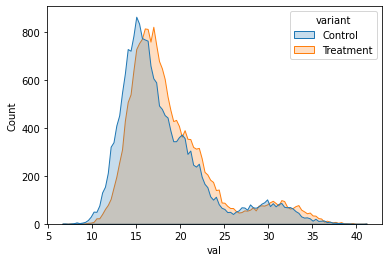

In [47]:
sns.histplot(data=df_combined.reset_index(), x="val", hue="variant", element="poly")

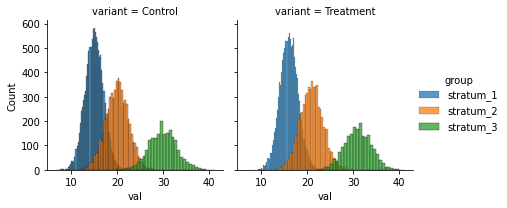

In [48]:
g = sns.FacetGrid(df_combined.reset_index(), col="variant", hue="group")
g.map_dataframe(sns.histplot, x="val")
g.add_legend()

## Считаем средние и дисперсию по двум кейсам: средневзвешенно по стратам и без их учета

### Без страт 

In [50]:
normal_te = pd.DataFrame({
    "effect_estimate": np.mean(df_treatment.val - df_control.val),
    "effect_estimate_se": np.sqrt(np.var(df_treatment.val) / len(df_treatment.val) + np.sqrt(np.var(df_control.val)) / len(df_control.val)),
    "n": len(df_treatment.val) + len(df_control.val)
}, index=[0])
print(normal_te)

   effect_estimate  effect_estimate_se      n
0          0.99308            0.039473  40000


In [51]:
def get_effect_estimate_se(treatment, control):
    return np.sqrt(np.var(treatment) / len(treatment) + np.sqrt(np.var(control)) / len(control))

def get_effect_estimate(treatment, control):
    return np.mean(treatment - control)

### По стратам

In [52]:
groups = {}
for k, group in df_combined.groupby(by="group"):
    cur_df = pd.DataFrame()
    for g, variant in group.groupby(by="variant"):
        cur_df = pd.concat([cur_df, variant])
    groups[k] = cur_df

In [53]:
effect_estimate_se = []
effect_estimate = []
n = []
stratums = []

for key, df in groups.items():
    control = df[df.variant=="Control"]
    treatment = df[df.variant=="Treatment"]
    effect_estimate_se.append(get_effect_estimate_se(treatment.val, control.val))
    effect_estimate.append(get_effect_estimate(treatment.val, control.val))
    n.append(len(df))
    stratums.append(key)
    
strat_te = pd.DataFrame({
    "group": stratums,
    "effect_estimate_se": effect_estimate_se,
    "effect_estimate": effect_estimate,
    "n": n
})

In [34]:
strat_te

,group,effect_estimate_se,effect_estimate,n
0,stratum_1,0.022258,1.014480,24000
1,stratum_2,0.038132,0.944277,12000
2,stratum_3,0.074979,1.011093,4000


##  Взвешенная оценка


Умножаем нашу метрику на вес страты

$$
\frac{n_k}{n} * metric
$$

In [57]:
strat_te["effect_estimate_se"] = strat_te["effect_estimate_se"] * strat_te["n"] / np.sum(strat_te["n"]) 
strat_te["effect_estimate"] = strat_te["effect_estimate"] * strat_te["n"] / np.sum(strat_te["n"])

In [58]:
strat_te

,group,effect_estimate_se,effect_estimate,n
0,stratum_1,0.013355,0.608688,24000
1,stratum_2,0.011440,0.283283,12000
2,stratum_3,0.007498,0.101109,4000


Суммируем по колонкам

In [59]:
strat_te = strat_te[["effect_estimate_se","effect_estimate","n"]].apply("sum")
strat_te

effect_estimate_se        0.032292
effect_estimate           0.993080
n                     40000.000000
dtype: float64

## Результаты

In [60]:
res = (1-(strat_te.effect_estimate_se / normal_te.effect_estimate_se))*100 
print(f"Сокращение дисперсии на {res[0]}%")

Сокращение дисперсии на 18.192384908419747%


In [39]:
strat_te

effect_estimate_se        0.032292
effect_estimate           0.993080
n                     40000.000000
dtype: float64

In [40]:
normal_te

,effect_estimate,effect_estimate_se,n
0,0.99308,0.039473,40000
